## **Some explore in Open Street Map library:**

In this notebook, I will use the data from `Open Street Map` to visualize the map of VietNam at a detailed level, including the street network, building network, and other infrastructure such as the water system.

The goals of this notebook:
- Explore how to extract specific data of a place using `Open Street Map`.
- Show the process of draw a map of `Ho Chi Minh City`
- 

In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from shapely.geometry import Point, MultiPolygon, Polygon
import json

Here I want to take Ho Chi Minh City as an example.
## **Ho Chi Minh City's map:**

Here, we will use function `geometries_from_place`, with the specific tag bellow to get the administrative unit in the lowest level.

For more tags, you can see here: [Map features](https://wiki.openstreetmap.org/wiki/Map_features#Aerialway)


In [2]:
city_name = "Ho Chi Minh City, Vietnam"

tags = {'boundary': 'administrative', 'admin_level': '8'}

hcm_boundary = ox.geometries_from_place(city_name, tags)
hcm_boundary.columns

Index(['geometry', 'alt_name', 'alt_name:en', 'alt_name:ko', 'alt_name:zh',
       'name', 'name:ar', 'name:cs', 'name:de', 'name:en', 'name:es',
       'name:fa', 'name:fr', 'name:hr', 'name:id', 'name:it', 'name:ja',
       'name:km', 'name:ko', 'name:ms', 'name:nl', 'name:ru', 'name:sk',
       'name:vi', 'name:vi-Hani', 'name:vi-US', 'name:zh', 'note',
       'official_name', 'place', 'population', 'ref', 'short_name',
       'short_name:en', 'short_name:vi', 'wikidata', 'wikipedia', 'name:bg',
       'name:sr', 'name:th', 'name:uk', 'name:ur', 'name:zh-Hans',
       'name:zh-Hant', 'name:sv', 'name:tg', 'name:tr', 'is_in:country_code',
       'source', 'description', 'start_date', 'natural', 'nodes',
       'admin_level', 'boundary', 'wetland', 'maritime', 'waterway',
       'border_type', 'motorcar', 'water', 'addr:district', 'addr:street',
       'addr:subdistrict', 'ways', 'ISO3166-2', 'type', 'name:fi', 'name:no',
       'name:pl', 'name:pt', 'name:ro', 'name:sw', 'name:ja-Hir

Here, we will make some explore in the data:

In [3]:
missing_ratios_df = hcm_boundary.apply(lambda column: (column.isnull().sum() / len(column)) * 100).to_frame()
missing_ratios_df.columns = ['Missing ratio']

missing_ratios_df

,Missing ratio
geometry,0.000000
alt_name,99.105915
alt_name:en,99.656121
alt_name:ko,99.931224
alt_name:zh,99.862448
...,...
is_in:country,99.724897
is_in:town,99.862448
is_in:state,99.862448
distance,99.931224


With the missing ratio above, we can drop all unnecessary columns which have missing ratio over 80%

In [4]:
cols_to_drop = missing_ratios_df[missing_ratios_df['Missing ratio'] > 80].index
cols_to_drop = cols_to_drop.to_list()

In [5]:
filtered_hcm_boundary = hcm_boundary.drop(cols_to_drop, axis= 1)

Currently, the data not just contains the administrative unit of `Ho Chi Minh City`, but it also have the data from some adjacent provinces, also is at inconsistent administrative levels. Therefore, we need to make some preprocessing step to extract the data of `Ho Chi Minh City`, at the desired administrative level.

 To get all the adminitrive unit of `Ho Chi Minh City`, we can use the other dataset here: [vietnam_dataset](https://github.com/thien0291/vietnam_dataset)

In [6]:
with open ('Index.json', 'r', encoding='utf-8') as file:
    province_code = json.load(file)

We also need to fix the relative path in the `Index.json`

In [247]:
# for province in province_code.values():
#     province['file_path'] = province['file_path'].replace("data", "admin_data")

# with open('Index.json', 'w', encoding='utf-8') as file:
#     json.dump(province_code, file, indent=2)

In [7]:
hcm_path = province_code['Hồ Chí Minh']['file_path']

with open (hcm_path, 'r', encoding='utf-8') as file:
    hcm = json.load(file)

We have load all necessary resources, now we'll extract the necessary data.
### **Extract data:**

Firsly, in the dataset, we have a column named `admin_level`, stand for the administrative level of the current value, at the district level, we can extract all rows that have `admin_level` is 6

In [19]:
hcm_district_boundary = filtered_hcm_boundary[filtered_hcm_boundary['admin_level'] == '6']

Then, from the administrative data, we can get all district's name in `Ho Chi Minh`

In [20]:
district_list = []
for district in hcm['district']:
    district_list.append(district['name'])

Net, we will extract all the row in `hcm_district_boundary` that have the value in column `name` is in the district list.

In [21]:
filtered_boundary = hcm_district_boundary.dropna(subset=['name']).copy()

def filter_district(row,col_name, list):
    return any(value in row[col_name] for value in list)

filter_boundary = filtered_boundary[filtered_boundary.apply(filter_district, axis=1, args=('name', district_list))]

filter_boundary

geometry  \
element_type osmid                                                         
relation     2587287   POLYGON ((106.68165 10.76546, 106.68197 10.765...   
             2764875   POLYGON ((106.69021 10.75208, 106.69068 10.752...   
             2778323   POLYGON ((106.68639 10.75184, 106.68653 10.752...   
             3797166   POLYGON ((106.68398 10.80994, 106.68413 10.810...   
             3819816   POLYGON ((106.66423 10.78711, 106.66427 10.787...   
             3820432   POLYGON ((106.65074 10.75340, 106.65075 10.753...   
             3851694   POLYGON ((106.66596 10.79086, 106.66617 10.791...   
             6228121   POLYGON ((106.65608 10.77775, 106.65656 10.778...   
             6228792   POLYGON ((106.62108 10.73405, 106.62110 10.734...   
             6846128   POLYGON ((106.60691 10.80606, 106.60700 10.806...   
             6846177   POLYGON ((106.62791 10.82467, 106.62865 10.825...   
             6846181   POLYGON ((106.63422 10.75900, 106.63441 10.759...   
             6888445   POLYGON ((106.59784 10.70180, 106.59871 10.702...   
             6908316   POLYGON ((106.63235 10.83299, 106.63267 10.833...   
             6909710   POLYGON ((106.55880 10.73645, 106.55891 10.737...   
             6923167   POLYGON ((106.60328 10.82623, 106.60374 10.828...   
             7157197   POLYGON ((106.67281 10.69233, 106.67365 10.695...   
             7157219   POLYGON ((106.49624 10.92072, 106.52095 10.917...   
             7157220   POLYGON ((106.35670 10.99160, 106.35819 10.992...   
             7157255   MULTIPOLYGON (((106.98323 10.49548, 106.98315 ...   
             7157268   POLYGON ((106.47215 10.76300, 106.47467 10.764...   
             11721235  POLYGON ((106.70284 10.83913, 106.70194 10.839...   

                                    name              name:en    wikidata  \
element_type osmid                                                          
relation     2587287              Quận 1           District 1    Q2299149   
             2764875              Quận 7           District 7    Q5283266   
             2778323              Quận 4           District 4    Q5283252   
             3797166     Quận Bình Thạnh  Binh Thanh District    Q2552692   
             3819816              Quận 3           District 3    Q1926820   
             3820432              Quận 5           District 5    Q2227258   
             3851694      Quận Phú Nhuận   Phu Nhuan District    Q2194003   
             6228121             Quận 10          District 10    Q1319891   
             6228792              Quận 6           District 6    Q1319931   
             6846128        Quận Tân Phú     Tan Phu District    Q7682100   
             6846177       Quận Tân Bình    Tan Binh District    Q2200028   
             6846181             Quận 11          District 11    Q1319960   
             6888445              Quận 8           District 8    Q5283273   
             6908316         Quận Gò Vấp      Go Vap District    Q5574953   
             6909710       Quận Bình Tân    Binh Tan District     Q610254   
             6923167             Quận 12          District 12    Q5283236   
             7157197        Huyện Nhà Bè      Nhà Bè District    Q4817238   
             7157219       Huyện Hóc Môn     Hoc Mon District    Q5875294   
             7157220        Huyện Củ Chi      Củ Chi District    Q1151196   
             7157255       Huyện Cần Giờ     Can Gio District     Q626340   
             7157268    Huyện Bình Chánh  Bình Chánh District    Q4914329   
             11721235  Thành phố Thủ Đức         Thu Duc City  Q104050371   

                           wikipedia  \
element_type osmid                     
relation     2587287             NaN   
             2764875             NaN   
             2778323             NaN   
             3797166             NaN   
             3819816             NaN   
             3820432             NaN   
             3851694             NaN   
             6228121          

Finally, we have the correct data of `Ho Chi Minh City`, now we can draw the map.

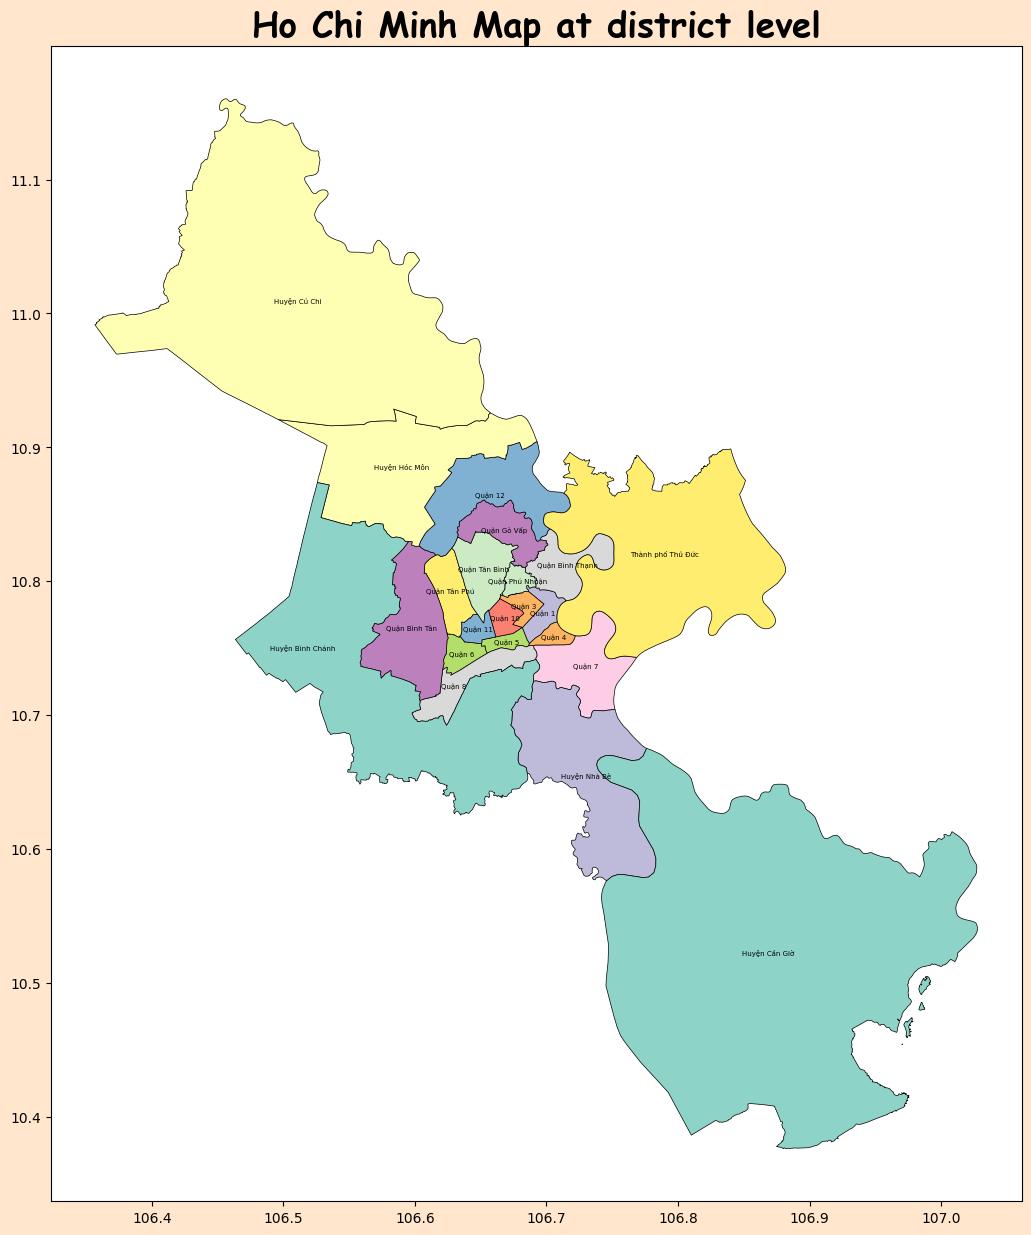

In [24]:

fig, ax = plt.subplots(figsize=(20, 15))
with plt.xkcd():
    filter_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.5, column = 'name', cmap = colormaps['Set3'] )

unique_labels = set()
for polygon, label in zip(filter_boundary.geometry, filter_boundary['name']):
    centroid = polygon.centroid
    
    if centroid.within(polygon):
        ax.text(centroid.x, centroid.y, label, fontsize=5, horizontalalignment='center', verticalalignment='center')
    else: 
        inside_point = polygon.representative_point()
        ax.text(inside_point.x, inside_point.y, label, fontsize=5, horizontalalignment='center', verticalalignment='center')
plt.title('Ho Chi Minh Map at district level', fontsize = 25, fontweight = 'bold', fontname='Comic Sans MS')
fig = plt.gcf()
fig.set_facecolor('#ffe6cc')
plt.show()

### **Higher level**
We can do the same process with the higher level

In [30]:
hcm_ward_boundary = filtered_hcm_boundary[filtered_hcm_boundary['admin_level'] == '8']

Then, we want to draw the map of all

In [32]:
ward_dict = {}
for district in hcm['district']:
    ward_list = []
    for ward in district['ward']:
        ward_list.append(ward['name'])
    ward_dict[district['name']] = ward_list

In [34]:
filtered_ward_boundary = hcm_ward_boundary.dropna(subset=['name']).copy()
ward_list = ward_dict['Quận 1']

filter_ward_boundary = filtered_ward_boundary[filtered_ward_boundary.apply(filter_district, axis=1, args=('name', ward_list))]

filter_ward_boundary

geometry  \
element_type osmid                                                        
relation     2559086  POLYGON ((106.68521 10.75645, 106.68537 10.756...   
             2561415  POLYGON ((106.68976 10.76161, 106.69061 10.762...   
             2561568  POLYGON ((106.69432 10.76681, 106.69535 10.768...   
             2561569  POLYGON ((106.69643 10.76922, 106.69693 10.769...   
             2561570  POLYGON ((106.68448 10.76837, 106.68501 10.768...   
             2587245  POLYGON ((106.68721 10.77125, 106.68943 10.773...   
             2587255  POLYGON ((106.69499 10.77958, 106.69586 10.780...   
             2587288  POLYGON ((106.68614 10.79250, 106.68628 10.792...   
             2587289  POLYGON ((106.69195 10.78789, 106.69319 10.789...   
             2587350  POLYGON ((106.68165 10.76546, 106.68197 10.765...   

                                         name                name:en  \
element_type osmid                                                     
relation     2559086           Phường Cầu Kho           Cau Kho Ward   
             2561415          Phường Cô Giang          Co Giang Ward   
             2561568      Phường Cầu Ông Lãnh      Cau Ong Lanh Ward   
             2561569  Phường Nguyễn Thái Bình  Nguyen Thai Binh Ward   
             2561570      Phường Phạm Ngũ Lão      Pham Ngu Lao Ward   
             2587245         Phường Bến Thành         Ben Thanh Ward   
             2587255          Phường Bến Nghé          Ben Nghe Ward   
             2587288          Phường Tân Định          Tan Dinh Ward   
             2587289            Phường Đa Kao            Da Kao Ward   
             2587350   Phường Nguyễn Cư Trinh   Nguyen Cu Trinh Ward   

                       wikidata                     wikipedia  \
element_type osmid                                              
relation     2559086  Q10752372                    vi:Cầu Kho   
             2561415  Q10751928          vi:Cô Giang (phường)   
             2561568  Q10752443      vi:Cầu Ông Lãnh (phường)   
             2561569  Q10799549  vi:Nguyễn Thái Bình (phường)   
             2561570  Q10806956       vi:Phạm Ngũ Lão, Quận 1   
             2587245  Q10743447         vi:Bến Thành (phường)   
             2587255  Q10743439          vi:Bến Nghé (phường)   
             2587288  Q32229505           vi:Tân Định, Quận 1   
             2587289  Q31994881                     vi:Đa Kao   
             2587350  Q10799027   vi:Nguyễn Cư Trinh (phường)   

                                                                  nodes  \
element_type osmid                                                        
relation     2559086  [[[2364089044, 2664205504, 4631208744, 4631208...   
             2561415  [[[1998235341, 8262974355, 1998235286, 1998235...   
             2561568  [[[1998504354, 1998781540, 1768347258, 1998235...   
             2561569  [[[1998504406, 1998781627, 1998235283, 1998504...   
             2561570  [[[2664205595, 8995419803, 2664205584], [26642...   
             2587245  [[[411924310, 4605032061, 4605032065, 46050320...   
             2587255  [[[1998781541, 9704134109, 4664527470, 4664527...   
             2587288  [[[729523333, 8262954994, 8262954995, 82629549...   
             2587289  [[[411926580, 8262956824], [2664205601, 411926...   
             2587350  [[[634134020, 1998781589, 4187322621], [418732...   

                     admin_level        boundary  \
element_type osmid                                 
relation     2559086           8  administrative   
             2561415           8  administrative   
             2561568           8  administrative   
             2561569           8  administrative   
             2561570           8  administrative   
             2587245           8  administrative   
             2587255           8  administrative   
             2587288           8  administrative   
             2587289           8  administrative   
             2587350           8  administr

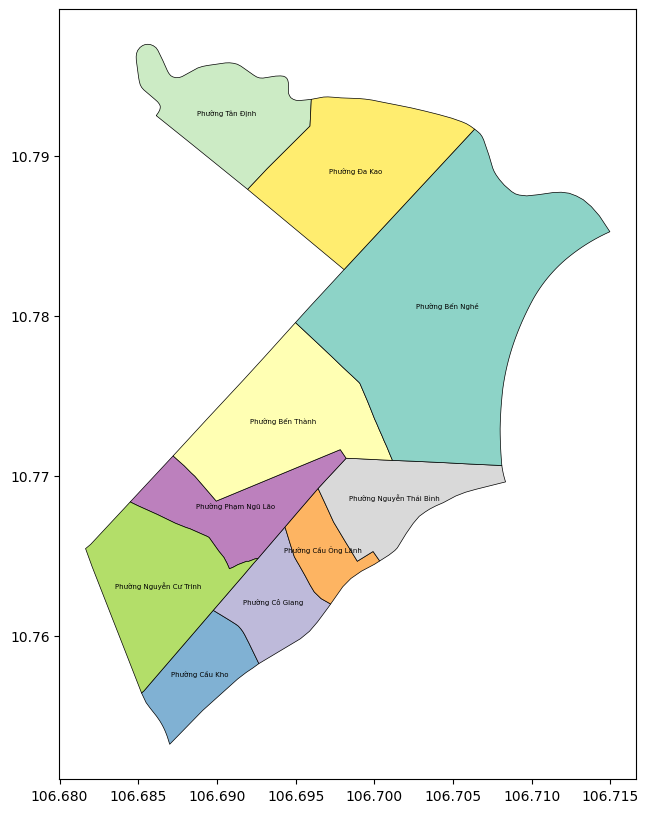

In [35]:

fig, ax = plt.subplots(figsize=(10, 10))

filter_ward_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.5, column = 'name', cmap = colormaps['Set3'] )

unique_labels = set()
for polygon, label in zip(filter_ward_boundary.geometry, filter_ward_boundary['name']):
    centroid = polygon.centroid
    
    if centroid.within(polygon):
        ax.text(centroid.x, centroid.y, label, fontsize=5, horizontalalignment='center', verticalalignment='center')
    else: 
        # Find a point inside the polygon
        inside_point = polygon.representative_point()
        ax.text(inside_point.x, inside_point.y, label, fontsize=5, horizontalalignment='center', verticalalignment='center')

plt.show()

### **The street network and more:**
Now we want to explore more about the street network

In [36]:
place = "Ho Chi Minh City, Vietnam"

street_network = ox.graph_from_place(place, network_type='all', simplify=False)
ox.plot_graph(street_network)

In [256]:
street_gdf = ox.graph_to_gdfs(street_network , nodes=False, edges=True)

In [257]:
street_gdf.columns

Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'lanes', 'maxspeed', 'tunnel', 'ref', 'service', 'access', 'junction',
       'width', 'geometry'],
      dtype='object')

In [ ]:
streets_dict = {}
for district in hcm['district']:
    street_list = []
    for street in district['street']:
        street_list.append(street)
    streets_dict[district['name']] = street_list

In [ ]:
filtered_rows = []
quan1_streets = streets_dict['Quận 1']
for index, row in street_gdf.dropna(subset='name').iterrows():

    street_name = row['name']
    if any(street in street_name for street in quan1_streets):
        filtered_rows.append(row)

quan1_street_network = gpd.GeoDataFrame(filtered_rows)

In [20]:
quan1_boundary = filter_boundary[filter_boundary['name'] == 'Quận 1']

In [ ]:
filtered_gdf = []
quan1_boundary_polygon = quan1_boundary['geometry'].iloc[0]

for index, row in street_gdf.iterrows():
    street = row['geometry']
  
    intersection = street.intersection(quan1_boundary_polygon)
    
    # Check if there is an intersection
    if not intersection.is_empty:
       
        if isinstance(intersection, LineString):
            filtered_gdf.append({'geometry': intersection})
        elif intersection.geom_type == 'MultiLineString':
            for segment in intersection:
                filtered_gdf.append({'geometry': segment})


quan1_street_network = gpd.GeoDataFrame(filtered_gdf)

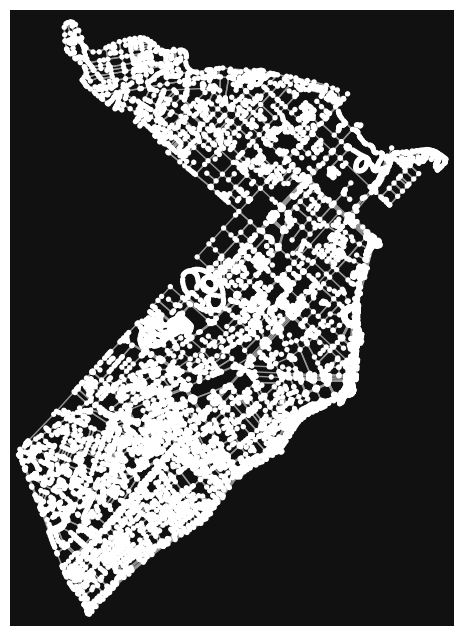

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
name = "District 1, Ho Chi Minh City, Vietnam"

street_network_1 = ox.graph_from_place(name, network_type='all', simplify=False)
ox.plot_graph(street_network_1)

In [18]:
street_network_1_gdf = ox.graph_to_gdfs(street_network_1 , nodes=False, edges=True)

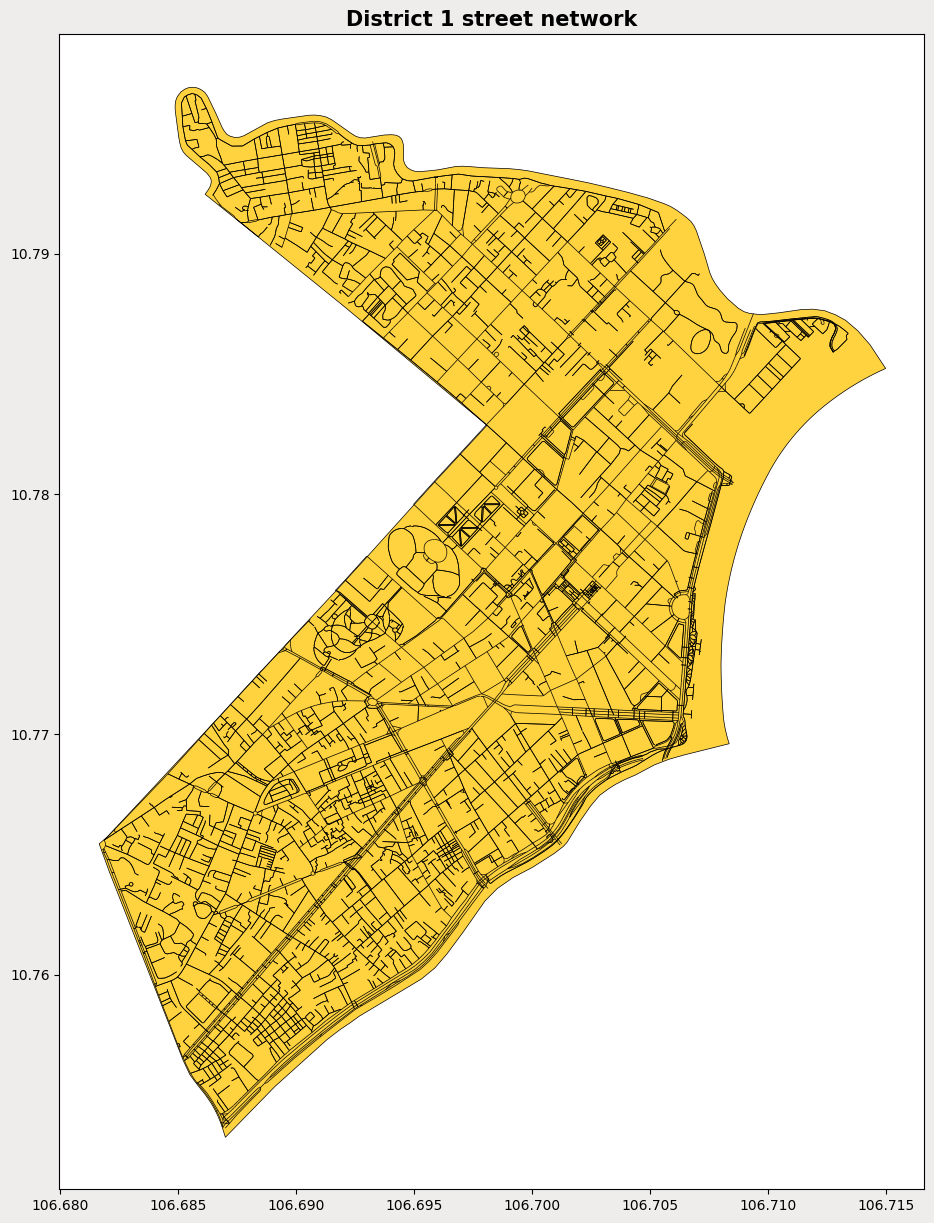

In [21]:

fig, ax = plt.subplots(figsize=(20, 15))

quan1_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.5, facecolor='#FFD23F' )
# quan1_street_network.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
street_network_1_gdf.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
plt.title('District 1 street network', fontsize = 15, fontweight = 'bold')
fig = plt.gcf()
fig.set_facecolor('#EFECEC')
plt.show()

In [263]:
street_gdf.to_file("hcm_street_network.geojson", driver='GeoJSON')

### **Water and trees:**

In [22]:
place_name = "Ho Chi Minh City, Vietnam"
tags = {'water':True}
water_network = ox.geometries_from_place(place_name, tags)
water_network.plot()


ChunkedEncodingError: ("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))

Now filter the water that in `District 1`

In [31]:
filtered_water_gdf = []
quan1_boundary_polygon = quan1_boundary['geometry'].iloc[0]

for index, row in water_network.iterrows():
    water = row['geometry']
  
    intersection = water.intersection(quan1_boundary_polygon)

    if not intersection.is_empty:
       
        if isinstance(intersection, Polygon):
            filtered_water_gdf.append({'geometry': intersection})
        elif intersection.geom_type == 'MultiLineString':
            for segment in intersection:
                filtered_water_gdf.append({'geometry': segment})


quan1_water_network = gpd.GeoDataFrame(filtered_water_gdf)

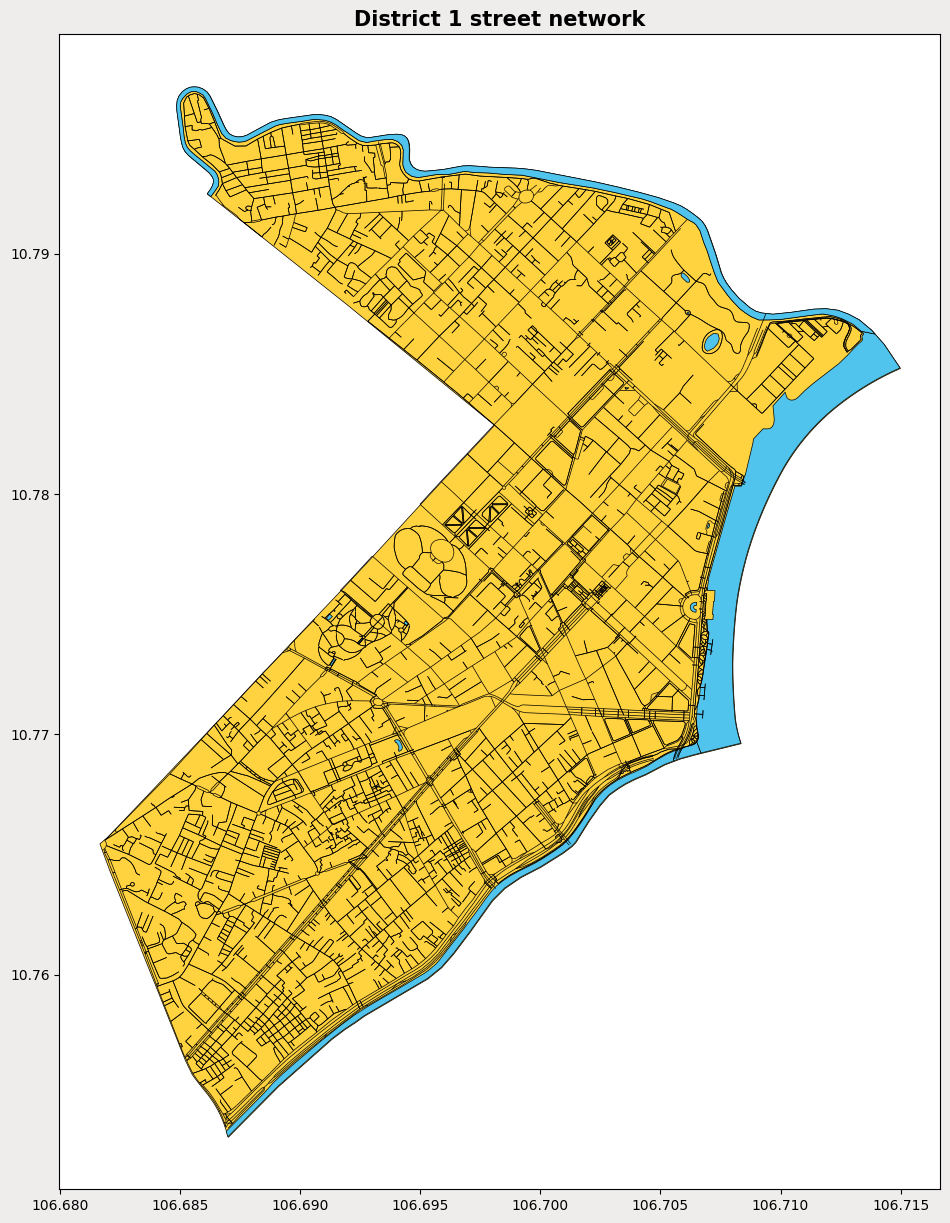

In [33]:
fig, ax = plt.subplots(figsize=(20, 15))

quan1_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.5, facecolor='#FFD23F' )
# quan1_street_network.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
street_network_1_gdf.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
quan1_water_network.plot(ax = ax, facecolor = '#50C4ED',  edgecolor='black', linewidth=0.5)
plt.title('District 1 street network', fontsize = 15, fontweight = 'bold')
fig = plt.gcf()
fig.set_facecolor('#EFECEC')
plt.show()

In [34]:
trees = ox.geometries_from_place(place_name, tags={'natural': 'tree'})

trees

natural                    geometry denotation  \
element_type osmid                                                        
node         2685441109     tree  POINT (106.66336 10.81401)        NaN   
             2940867815     tree  POINT (106.71839 10.72760)        NaN   
             2940867816     tree  POINT (106.71825 10.72765)        NaN   
             2940867817     tree  POINT (106.71808 10.72773)        NaN   
             2940867818     tree  POINT (106.71856 10.72758)        NaN   
...                          ...                         ...        ...   
             11676130394    tree  POINT (106.66445 10.81265)        NaN   
             11676130395    tree  POINT (106.66441 10.81285)        NaN   
             11676130396    tree  POINT (106.66449 10.81297)        NaN   
             11676130397    tree  POINT (106.66447 10.81293)        NaN   
             11676130398    tree  POINT (106.66445 10.81291)        NaN   

                         leaf_cycle leaf_type name:en leisure source  
element_type osmid                                                    
node         2685441109         NaN       NaN     NaN     NaN    NaN  
             2940867815         NaN       NaN     NaN     NaN    NaN  
             2940867816         NaN       NaN     NaN     NaN    NaN  
             2940867817         NaN       NaN     NaN     NaN    NaN  
             2940867818         NaN       NaN     NaN     NaN    NaN  
...                             ...       ...     ...     ...    ...  
             11676130394        NaN       NaN     NaN     NaN    NaN  
             11676130395        NaN       NaN     NaN     NaN    NaN  
             11676130396        NaN       NaN     NaN     NaN    NaN  
             11676130397        NaN       NaN     NaN     NaN    NaN  
             11676130398        NaN       NaN     NaN     NaN    NaN  

[2809 rows x 8 columns]

In [35]:
filtered_tree_gdf = []

for index, row in trees.iterrows():
    tree = row['geometry']
  
    if quan1_boundary_polygon.intersects(tree):
        filtered_tree_gdf.append({'geometry': tree})

quan1_tree_network = gpd.GeoDataFrame(filtered_tree_gdf)


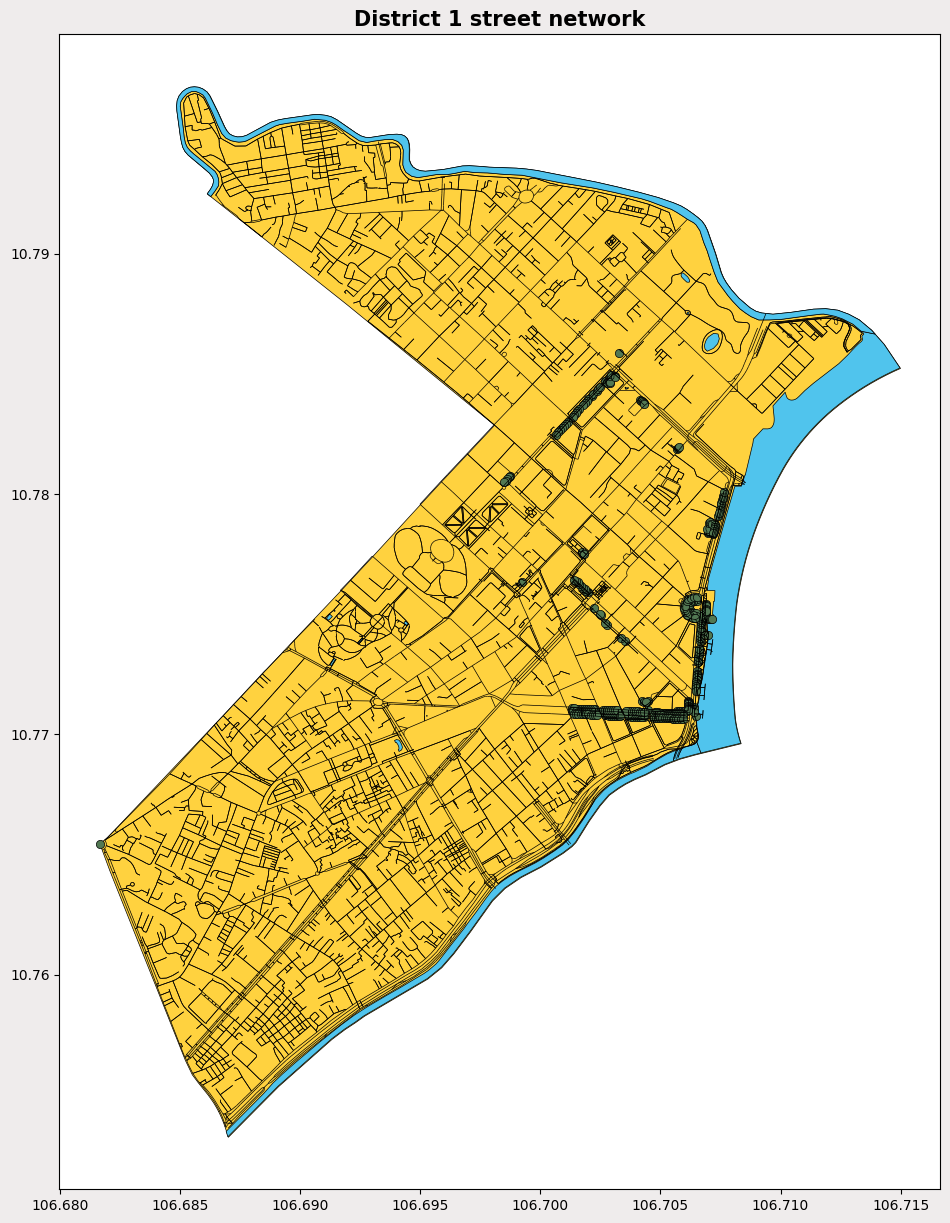

In [36]:
fig, ax = plt.subplots(figsize=(20, 15))

quan1_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.5, facecolor='#FFD23F' )
# quan1_street_network.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
street_network_1_gdf.plot(ax = ax, edgecolor = 'black', linewidth = 0.5)
quan1_water_network.plot(ax = ax, facecolor = '#50C4ED',  edgecolor='black', linewidth=0.5)
quan1_tree_network.plot(ax = ax, facecolor = '#527853',  edgecolor='black', linewidth=0.5)
plt.title('District 1 street network', fontsize = 15, fontweight = 'bold')
fig = plt.gcf()
fig.set_facecolor('#EFECEC')
plt.show()

### **Buildings:**

<Axes: >

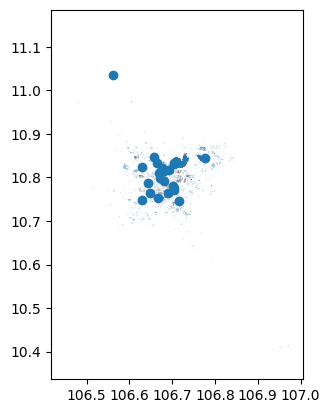

In [37]:

buildings = ox.geometries_from_place(place_name, tags={'building': True})

buildings.plot()

In [70]:
filtered_building_gdf = []

for index, row in buildings.iterrows():
    building = row['geometry']
  
    if isinstance(building, Point):
        if quan1_boundary_polygon.intersects(building):
            filtered_building_gdf.append({'geometry': building})

    elif isinstance(building, Polygon):
        intersection = building.intersection(quan1_boundary_polygon)

        if not intersection.is_empty:
            if isinstance(intersection, Polygon):
                filtered_building_gdf.append({'geometry': intersection})

    elif isinstance(building, MultiPolygon):

        intersection= building.intersection(quan1_boundary_polygon)
    
        if not intersection.is_empty:
            filtered_building_gdf.append({'geometry': intersection})

quan1_building_network = gpd.GeoDataFrame(filtered_building_gdf)

In [71]:
quan1_building_network

,geometry
0,POINT (106.69071 10.76527)
1,POINT (106.70301 10.77649)
2,POINT (106.70230 10.78089)
3,POINT (106.70414 10.77110)
4,"POLYGON ((106.70011 10.77962, 106.69994 10.779..."
...,...
2799,"POLYGON ((106.69369 10.76298, 106.69341 10.763..."
2800,"POLYGON ((106.69304 10.79242, 106.69288 10.792..."
2801,"MULTIPOLYGON (((106.69833 10.76828, 106.69846 ..."
2802,"POLYGON ((106.70270 10.78998, 106.70244 10.789..."


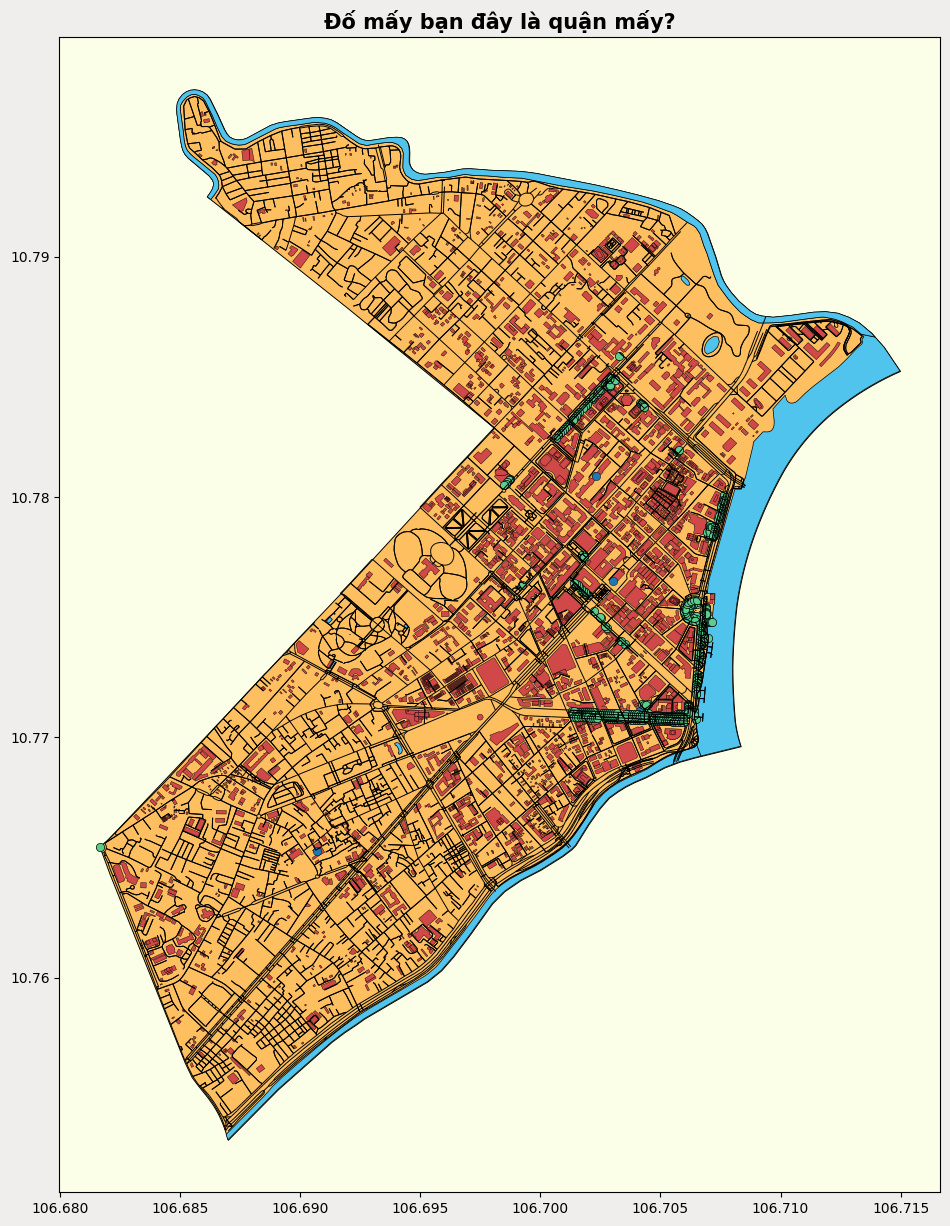

In [72]:
fig, ax = plt.subplots(figsize=(20, 15))


quan1_boundary.plot(ax = ax,  edgecolor='black', linewidth=0.7, facecolor='#FDBF60' )
quan1_building_network.plot(ax = ax, facecolor = '#D04848',  edgecolor='black', linewidth=0.3)
street_network_1_gdf.plot(ax = ax, edgecolor = 'black', linewidth = 0.7)
quan1_water_network.plot(ax = ax, facecolor = '#50C4ED',  edgecolor='black', linewidth=0.5)
quan1_tree_network.plot(ax = ax, facecolor = '#59CE8F',  edgecolor='black', linewidth=0.5)


plt.title('Đố mấy bạn đây là quận mấy?', fontsize = 15, fontweight = 'bold')
fig = plt.gcf()
fig.set_facecolor('#F0EEED')
ax.set_facecolor('#FCFFE7')
plt.show()